# Practical Implementation

In [136]:
import tf
%store -r X_train_80 y_train_80 X_test_20 y_test_20
X_train_80 = X_train_80
y_train_80 = y_train_80

X_test_20 = X_test_20
y_test_20 = y_test_20

## Baseline Accuracy
The baseline accuracy is the accuracy that can be achieved by a model that always predicts the majority class. It's a useful metric to have because it allows us to know the minimum performance that a model should achieve.
 
In general if a model cannot outperform the baseline, it's not worth using it.

In [137]:
baseline_acc = y_train_80.value_counts(normalize=True).max()
print(f"Majority Class Baseline Accuracy On Train: {baseline_acc:.4f}")

Majority Class Baseline Accuracy On Train: 0.9150


In [138]:
baseline_acc_test = y_test_20.value_counts(normalize=True).max()
print(f"Majority Class Baseline Accuracy On Test: {baseline_acc_test:.4f}")

Majority Class Baseline Accuracy On Test: 0.9150


## Splitting the Training Set in Train and Validation

In [139]:
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_80, y_train_80, test_size=0.2, random_state=42, stratify=y_train_80
)

We will use **the same** validation set for all the models, in order to have a fair comparison.

## Utility Functions

### Plotting Functions

In [140]:
from utility_functions import plot_acc_loss
from utility_functions import plot_roc_curve


### Evaluation Functions

In [141]:
from utility_functions import evaluate_classification_model

## Evaluation Metrics

### F1 Score
The accuracy is not always the best metric to use when evaluating a classification model. A silly example could be a model that always predicts the majority class. This model would have a very high accuracy, but it would not be useful at all. The F1 score is a metric that combines precision and recall. It is defined as the harmonic mean of precision and recall: $F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$
### Precision
Precision is the ratio of true positives to the sum of true positives and false positives. It measures how many of the samples predicted as positive are actually positive. $precision = \frac{TP}{TP + FP}$

### Recall
Recall is the ratio of true positives to the sum of true positives and false negatives. It measures how many of the positive samples are captured by the positive predictions. $recall = \frac{TP}{TP + FN}$

### ROC Curve
The ROC curve is an instrument used to visualize the performance of a binary classification model. It plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
 The closer the curve is to the top left corner, the better the model is. The area under the curve (AUC) is also a useful metric to compare different models. In general: The higher the AUC, the better the model is.
 
![roc](images/roc.png)

Image credit: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=it#:~:text=AUC%20stands%20for%20%22Area%20under,across%20all%20possible%20classification%20thresholds.


# Simple Model
Since there are few features, probably a simple model will be enough. Always for this reason, we wont use the dropout technique, which is used in complex models to avoid overfitting.


## Training

In [142]:
from keras.src.layers import Dense
from keras import Sequential
from keras.src.optimizers import Adam

In [143]:
simple_model = Sequential()

simple_model.add(Dense(16,
                input_dim=X_train_80.shape[1], 
                activation='relu'))

simple_model.add(Dense(8, activation='relu')) ## relu is more stable and faster than sigmoid


simple_model.add(Dense(1, activation='sigmoid'))


### Weights
save the initial weights to use them later for a fair comparison with the model with class weights

In [144]:
weights = simple_model.get_weights() 

In [145]:
adam = Adam(learning_rate=0.01)

simple_model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])



In [146]:
from keras.src.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
simple_hist = simple_model.fit(X_train_split, y_train_split, 
                 epochs=100, 
                 batch_size=64, 
                 validation_data = (X_val_split, y_val_split),
                verbose=0,
                callbacks=[early_stopping])

Restoring model weights from the end of the best epoch: 31.
Epoch 41: early stopping


### Plot the change in accuracy and loss during training

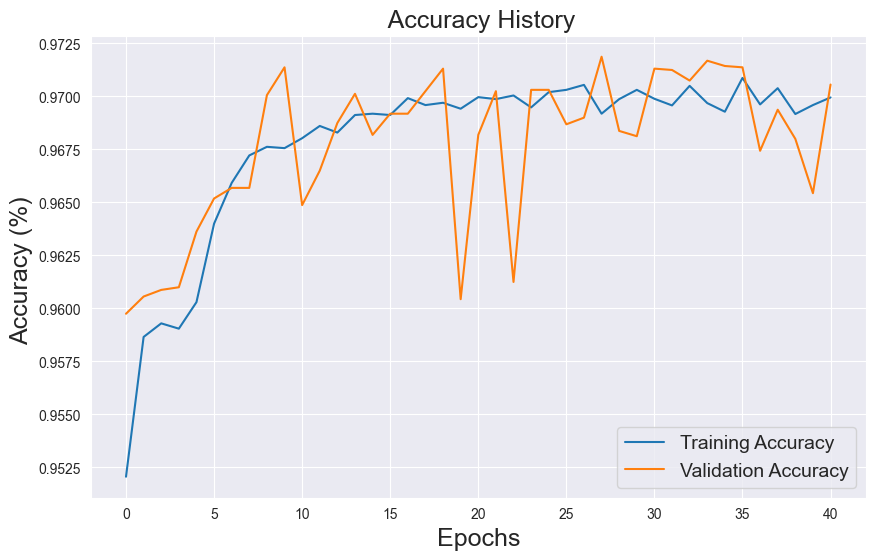

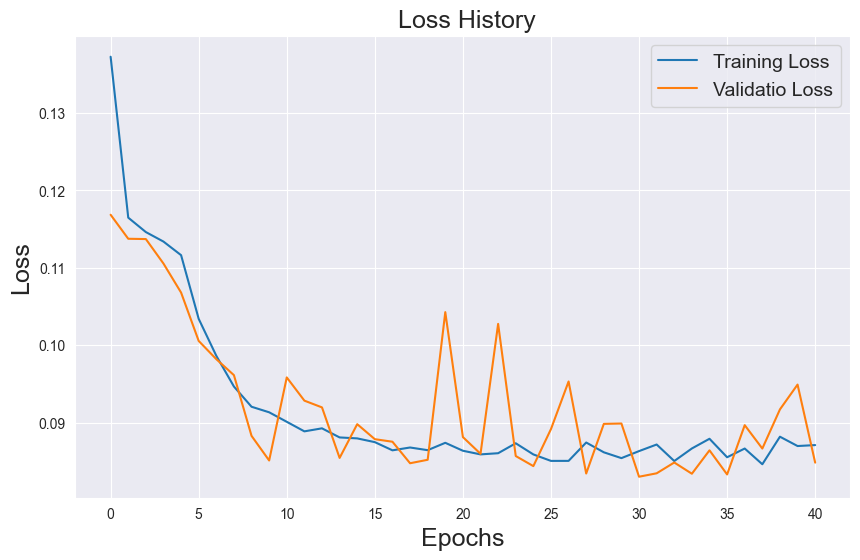

In [147]:
plot_acc_loss(simple_hist)

### Early Stopping
Early Stopping is a technique that automatically stops the training of a model when its performance on a validation set stops improving. It relies on two key parameters: "patience" (representing the number of epochs the model will wait without seeing improvements in the performance of the validation set) and "restore_best_weights" (restores the weights from the best epoch). This way, there's no need to manually decide the number of epochs; the model stops when it has learned enough without overfitting. This helps us achieve a model that generalizes well to new data without adapting excessively to the training set.

## Testing

625/625 [==============================] - 0s 702us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       1.00      0.66      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:


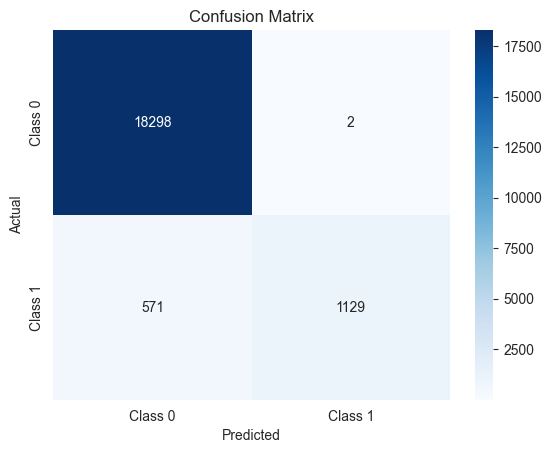

In [148]:
evaluate_classification_model(simple_model, X_test_20, y_test_20)

625/625 [==============================] - 1s 727us/step


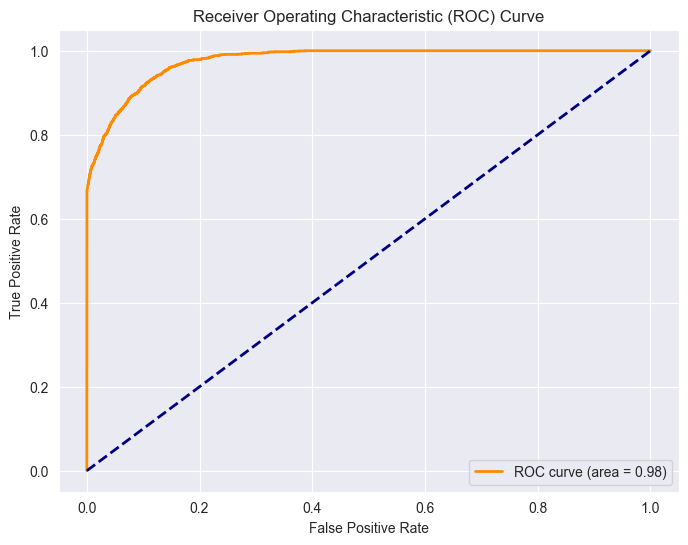

In [149]:
plot_roc_curve(simple_model, X_test_20, y_test_20)

## Considerations

What if the model is too simple? What if it's not able to capture the complexity of the data? We can try to make it more complex by adding more layers and neurons. This will allow the model to learn more complex patterns in the data. However, this comes at the cost of increased training time and a higher risk of overfitting.

Even though the model is simple, it's able to achieve an AUC of 0.98.


### Saving the model

In [150]:
simple_model.save('simple_model')

INFO:tensorflow:Assets written to: simple_model/assets


INFO:tensorflow:Assets written to: simple_model/assets


# Complex Model
We can create a more complex model by adding more layers and neurons. This will allow the model to learn more complex patterns in the data. However, this comes at the cost of increased training time and a higher risk of overfitting.


## Training

In [151]:
from keras.src.layers import Dense
from keras import Sequential
from keras.src.optimizers import Adam

complex_model = Sequential()

complex_model.add(Dense(16,
                       input_dim=X_train_80.shape[1],
                       activation='relu'))

complex_model.add(Dense(16, activation='relu'))  ## The New Layer
complex_model.add(Dense(8, activation='relu'))  ## relu is more stable and faster than sigmoid

complex_model.add(Dense(1, activation='sigmoid'))


### Weights
Note that in this case we won't use the weights of the simple model because the architecture is different.

In [152]:

adam = Adam(learning_rate=0.01)

complex_model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])


complex_model.fit(X_train_split, y_train_split, 
                 epochs=100, 
                 batch_size=64, 
                 validation_data=(X_val_split, y_val_split),
                 verbose=0,
                 callbacks=[early_stopping])


Restoring model weights from the end of the best epoch: 24.
Epoch 34: early stopping


## Testing


625/625 [==============================] - 0s 617us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:


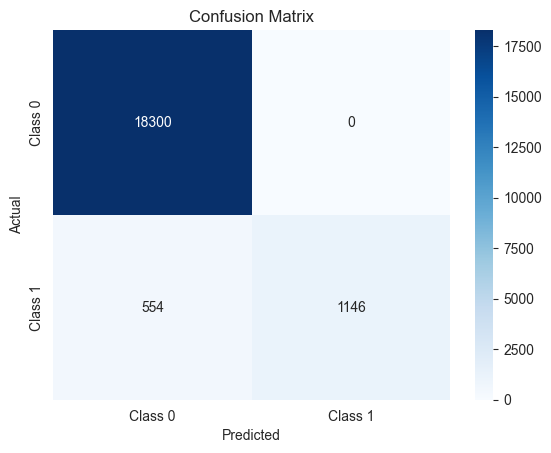

In [153]:
evaluate_classification_model(complex_model, X_test_20, y_test_20)


## Considerations
The complex of the model does not justify the performance.
I would prefer the simple model because it's faster to train. The complex model is more prone to overfitting and **it's not worth** the effort.


### Saving the model

In [154]:
complex_model.save('complex_model')

INFO:tensorflow:Assets written to: complex_model/assets


INFO:tensorflow:Assets written to: complex_model/assets


# Class Weight Model

We can try to improve the simple_model by balancing the classes. We can do this by assigning weights to the classes. The weights will be used to penalize the loss function during training. The idea is to increase the loss for the minority class and decrease the loss for the majority class. This will force the model to pay more attention to the minority class and hopefully improve the results.

## Training

In [155]:
y_train_80.value_counts()

diabetes
0    73200
1     6800
Name: count, dtype: int64

In [156]:
import numpy as np
from sklearn.utils import compute_class_weight

y_train_series = y_train_80

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_series), y=y_train_series)
# In this way the weight of each class is inversely proportional to its frequency

# Build the class weight dictionary
class_weight_dict = dict(enumerate(class_weights))

# Define the model
weighted_model = Sequential()

weighted_model.add(Dense(16, input_dim=X_train_80.shape[1], activation='relu'))
weighted_model.add(Dense(8, activation='relu'))
weighted_model.add(Dense(1, activation='sigmoid'))

weighted_model.set_weights(weights)

adam = Adam(learning_rate=0.01)

# Compile the model with class weights
weighted_model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])

# Train the model with class weights
hist = weighted_model.fit(X_train_split, y_train_split,
          class_weight=class_weight_dict,
          epochs=100, 
          batch_size=64,
          validation_data=(X_val_split, y_val_split),
          callbacks=[early_stopping],
          verbose=0)

weighted_model.save_weights('firstTrainWM.h5')


Restoring model weights from the end of the best epoch: 25.
Epoch 35: early stopping


### Plot the change in accuracy and loss during training

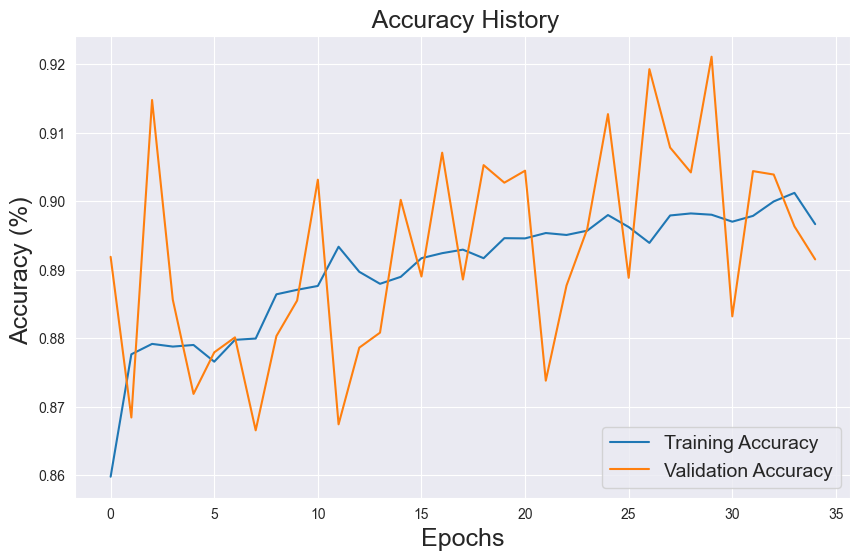

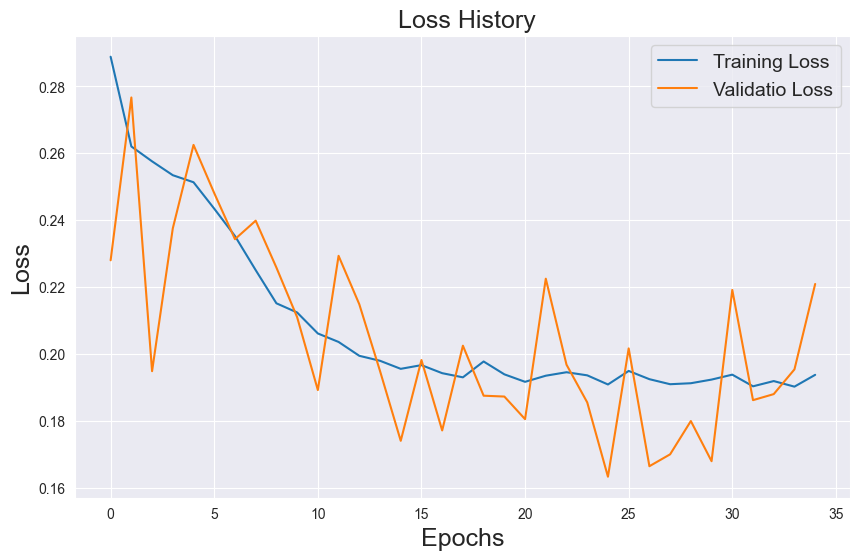

In [157]:
plot_acc_loss(hist)

The instability in the loss is likely a result of the model assigning excessive importance to the minority class. This suggests that the model may be attempting to overly adapt to the class with the highest weight, compromising overall stability.


### Trying to stabilize the model

In [158]:
early_stopping = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True, verbose=1)

weighted_model.load_weights('firstTrainWM.h5')

stable_hist = weighted_model.fit(X_train_split, y_train_split,
          class_weight=class_weight_dict,
          epochs=100, 
          batch_size=256, # We increase the batch size to reduce the instability
          validation_data=(X_val_split, y_val_split),
          callbacks=[early_stopping],
          verbose=0)    



Restoring model weights from the end of the best epoch: 26.
Epoch 41: early stopping


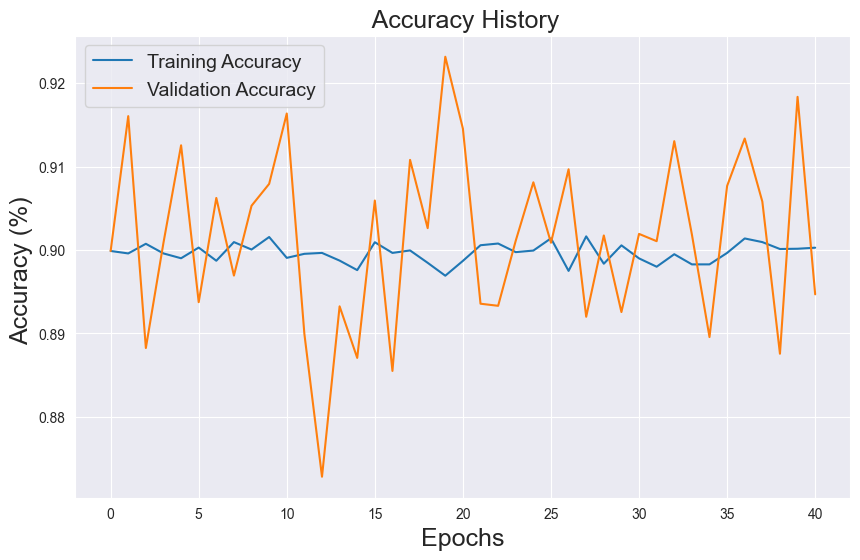

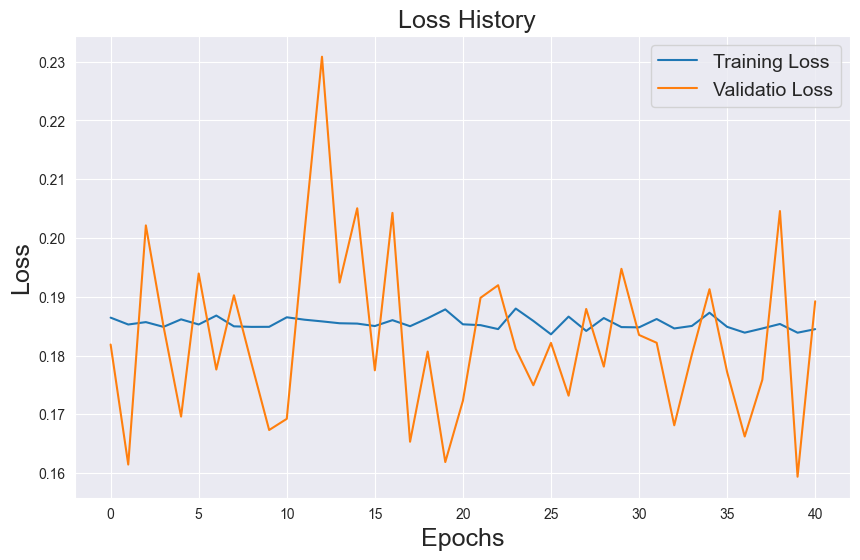

In [159]:
plot_acc_loss(stable_hist)

It seems that increasing the batch size is not enough to stabilize the model. The instability is due to the intrinsic nature of the problem. The loss is more penalized for the minority class, so the model is trying to adapt to it.

## Testing

625/625 [==============================] - 1s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.46      0.92      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.90      0.92     20000


Confusion Matrix:


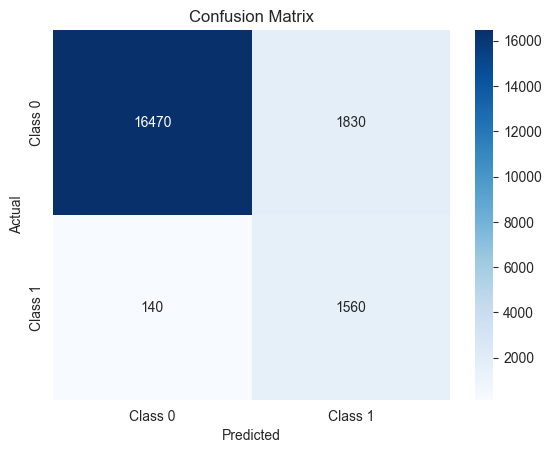

In [160]:
evaluate_classification_model(weighted_model, X_test_20, y_test_20)

### Test set considerations: What happened ?

Looking at the results.. it seams like the  weighted model is going worse than the simple model... 
But is it really so?
Maybe, sometimes you have just to change the point of view. 


### Changing the point of view: evaluate the model

625/625 [==============================] - 0s 756us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.46      0.92      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.90      0.92     20000


Confusion Matrix:


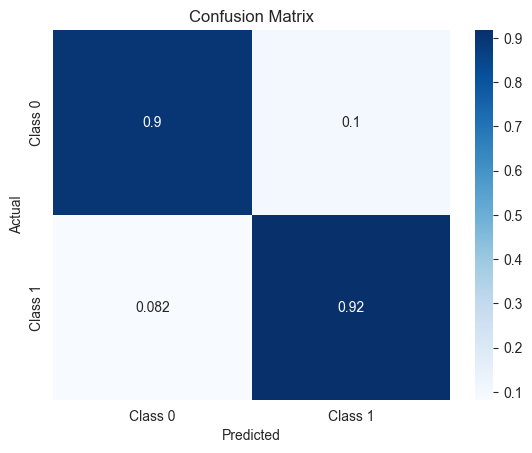

In [161]:
evaluate_classification_model(weighted_model, X_test_20, y_test_20, normalize_param='true')

Now we can see that the model is actually doing a better job of identifying positive cases, without a signficant icrease in the number of false positives.

625/625 [==============================] - 1s 855us/step


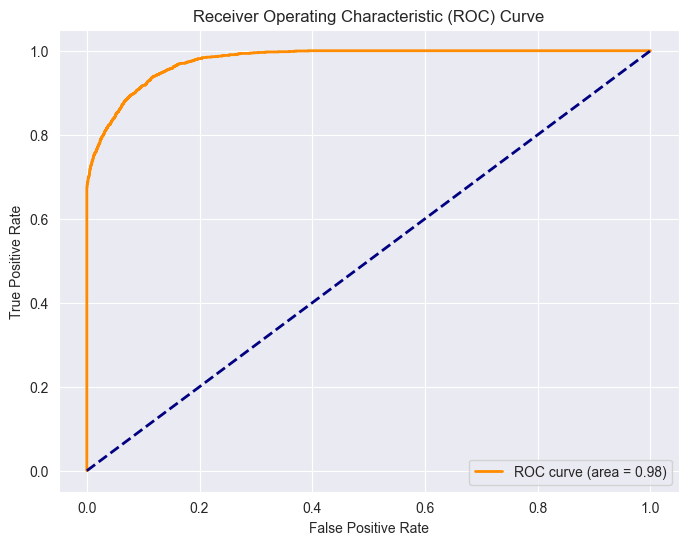

In [162]:
plot_roc_curve(weighted_model, X_test_20, y_test_20)

## Considerations
So initially we thought that the model with class weights was not performing well. However, when we looked at the results from a different perspective, we realized that the model was actually doing a better job of identifying positive cases. This is because we're trying to fix mistakes in one group but end up changing things in another.

In our case scenario, we would prefer to have a model that is able to identify more cases of diabetes, even if it means making more mistakes in the process. This is because we want to prioritize the identification of individuals who may be unwell. 

It's important to note that balancing the classes does not always make the model perform better. We need to explore different approaches to find what works best.

Note: the AUC is still 0.98, we will discuss this later.


### Saving the model

In [163]:
weighted_model.save('weighted_model')

INFO:tensorflow:Assets written to: weighted_model/assets


INFO:tensorflow:Assets written to: weighted_model/assets


# Compare the two models


In [164]:
from utility_functions import evaluate_classification_models, plot_roc_curves


## Evaluation on Test Set

625/625 [==============================] - 1s 850us/step

Classification Report - Model 1:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       1.00      0.66      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.83      0.89     20000
weighted avg       0.97      0.97      0.97     20000
625/625 [==============================] - 1s 1ms/step

Classification Report - Model 2:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.46      0.92      0.61      1700

    accuracy                           0.90     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.90      0.92     20000


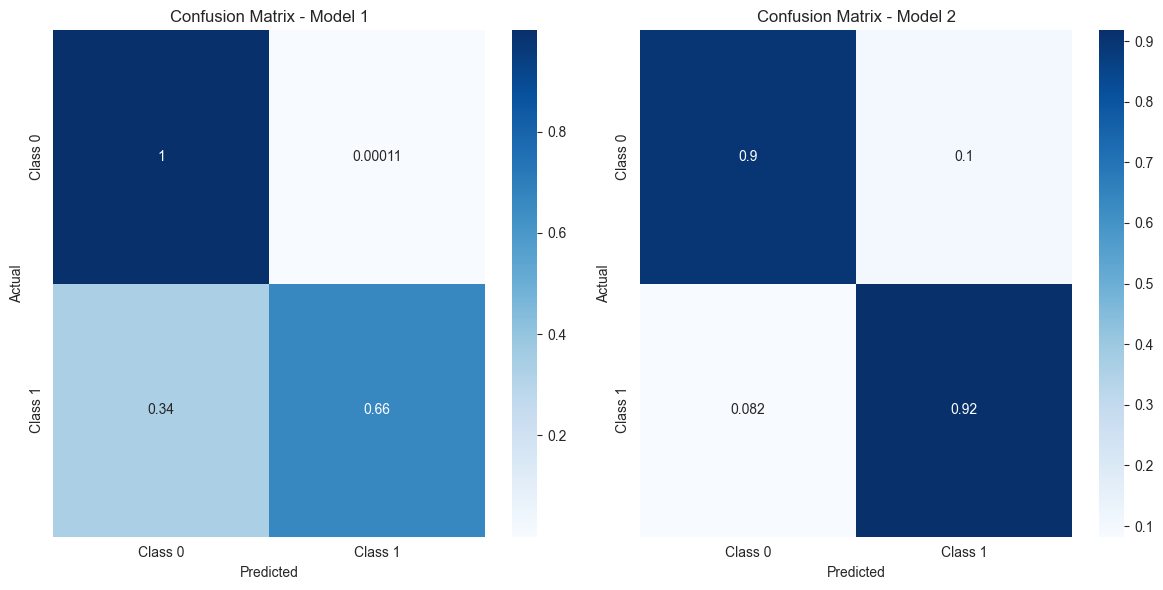

In [165]:
models = [simple_model, weighted_model] # model1, model2
evaluate_classification_models(models, X_test_20, y_test_20, normalize_param='true')

## Plotting ROC Curves

625/625 [==============================] - 0s 731us/step


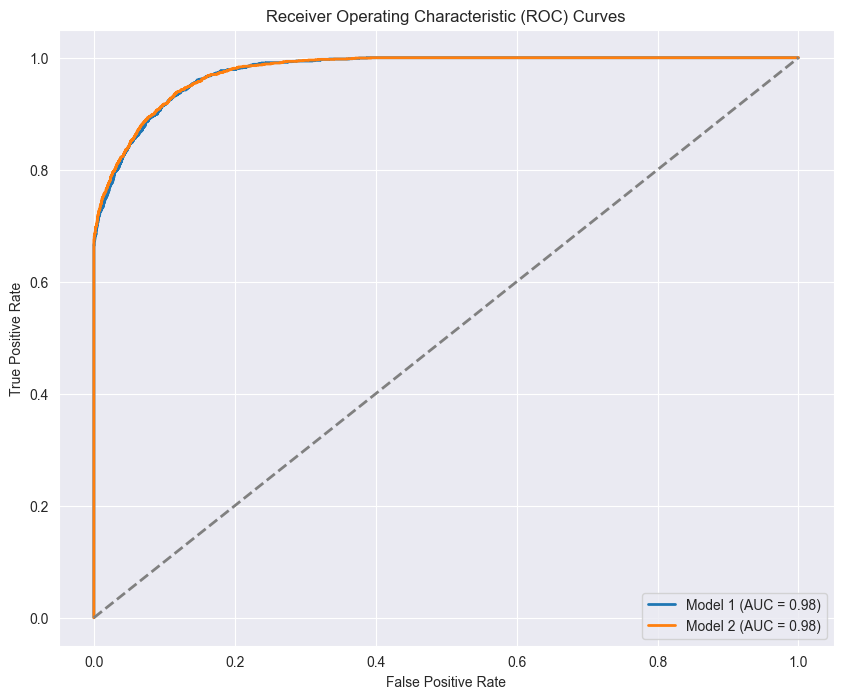

In [166]:
plot_roc_curves(models, X_test_20, y_test_20)

## Considerations
We've tuned the model to predict positive cases more frequently, capturing additional instances of actual positives. This adjustment led to an improvement in recall with a significant loss in precision. In our application context, prioritizing the identification of individuals who may be unwell is more crucial than potentially allowing those who are genuinely unwell to go undetected.

We cannot claim full satisfaction with the results obtained through class balancing, but we can say that the model **is more suitable for our application context**.

The suboptimal outcomes may be attributed to the lack of robust features in our dataset, which could limit the effectiveness of class balancing strategies.

Note that the AUC is the same for both models, probably because we are shifting the error from one group to another, ending up being wrong, somehow, in the same way.
 In general the AUC measure the capacity of the model to distinguish between classe at all classification thresholds.


# Final Model

## Training

### Fine Tuning
We can improve our final model by training it on the validation set as well. This will allow the model to learn from more data and hopefully improve its performance.

In [171]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
last_hist = weighted_model.fit(X_train_80, y_train_80,
          class_weight=class_weight_dict,
          epochs=100, 
          batch_size=64,
          callbacks=[early_stopping],
          verbose=0)


Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping


## Testing

625/625 [==============================] - 0s 638us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     18300
           1       0.53      0.89      0.66      1700

    accuracy                           0.92     20000
   macro avg       0.76      0.91      0.81     20000
weighted avg       0.95      0.92      0.93     20000


Confusion Matrix:


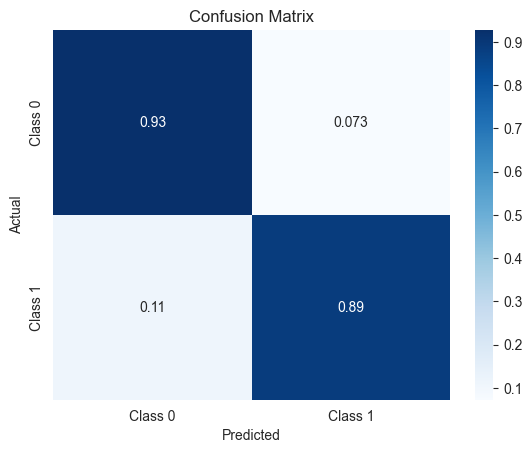

In [172]:
evaluate_classification_model(weighted_model, X_test_20, y_test_20, normalize_param='true')

625/625 [==============================] - 1s 1ms/step


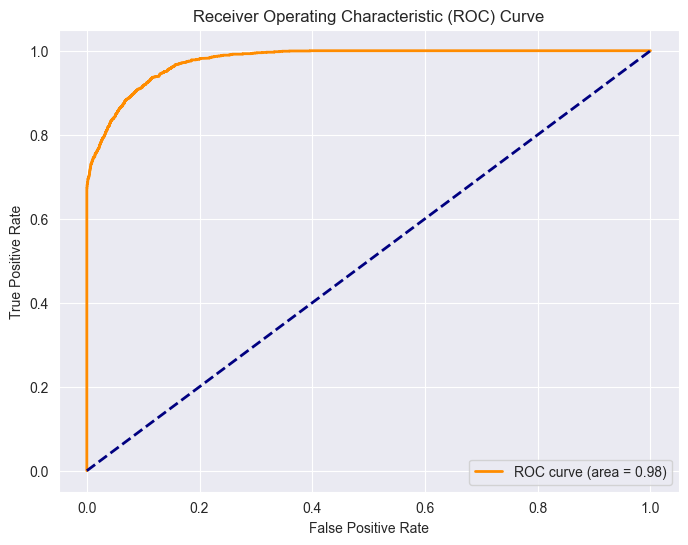

In [173]:
plot_roc_curve(weighted_model, X_test_20, y_test_20)


# Conclusion : To sum up
Initially, we started creating a simple model. We then tried to improve it by making it more complex. However, we realized that the simple model was actually performing better. 
We then tried to improve the simple model by balancing the classes, initially thinking that the model was not performing well. However, when we looked at the results from a different perspective, we realized that the model was actually doing a better job in our application context.
We then fine-tuned the model by training it on the validation set as well. This allowed the model to learn from more data and hopefully improve its performance.

## Save the final model

In [174]:
weighted_model.save('final_model')

INFO:tensorflow:Assets written to: final_model/assets


INFO:tensorflow:Assets written to: final_model/assets


# References
1. Tan, P.-N., Steinbach, M., & Kumar, V. (Year). *Introduction to Data Mining* (2nd ed.). Publisher.
2. https://www.geeksforgeeks.org/auc-roc-curve/#what-is-the-aucroc-curve
3. https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=it#:~:text=AUC%20stands%20for%20%22Area%20under,across%20all%20possible%20classification%20thresholds.
